In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import icecream as ic
from sklearn import feature_selection as fs, model_selection, linear_model, tree, ensemble, svm, metrics, preprocessing
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from skopt import space, gp_minimize
from functools import partial

import logging
import os
import warnings
warnings.filterwarnings('ignore')


logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [2]:
data = pd.read_csv("../input/train.csv")
y = data['price_range']
X = data.drop("price_range", axis = 1)

# 1 - Exploratory Data Analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

- The dataset has no missing values, we can directly move on to EDA without worrying about data cleaning

In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data.head())
print(data.shape)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


(2000, 21)


## Impact of ram and battery power on the price_range

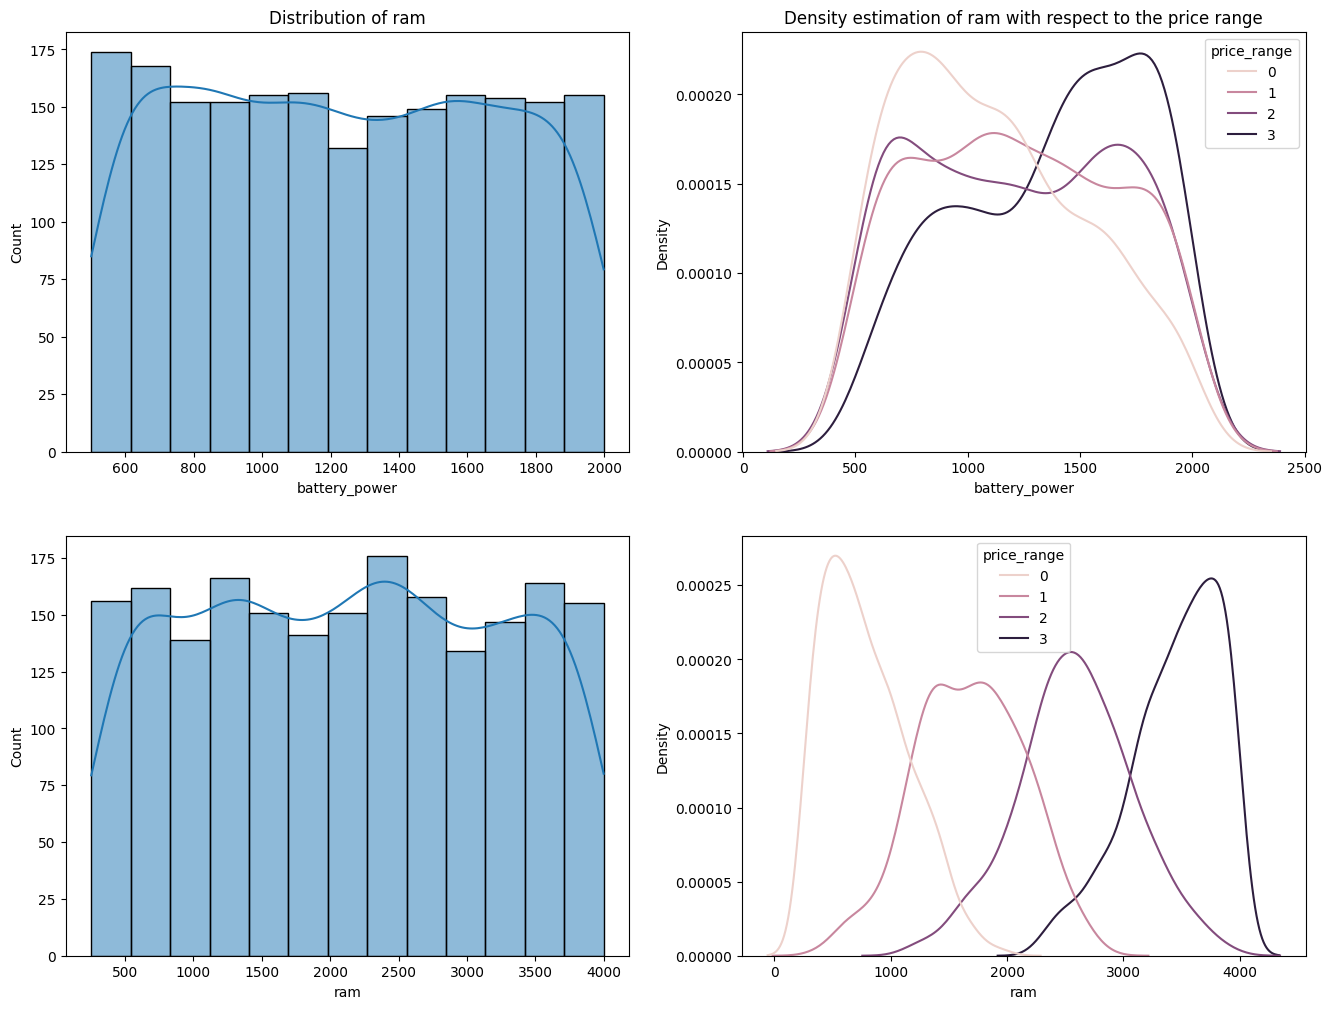

In [5]:
fig, ax = plt.subplots(2,2, figsize = (16,12))
ax = ax.flatten()
sns.histplot(data = data, x = "battery_power", kde = True, ax = ax[0])
sns.kdeplot(data = data, x = "battery_power", hue = "price_range", ax = ax[1])
sns.histplot(data = data, x = "ram", kde = True, ax = ax[2])
sns.kdeplot(data = data, x = "ram", hue = "price_range", ax = ax[3])
ax[0].title.set_text('Distribution of battery power')
ax[1].title.set_text('Density estimation of the battery power with respect to the price range')
ax[0].title.set_text('Distribution of ram')
ax[1].title.set_text('Density estimation of ram with respect to the price range')

- Ram and battery power are 2 of the main technical features of a mobile phone. As one could imagine, they are good predictors for the price range even though their distributions are uniform, the higher both these features are, the higher the price range is.

## Impact of Dual Sim on the price range

Text(0.5, 1.0, "Dual sim's impact on the price range")

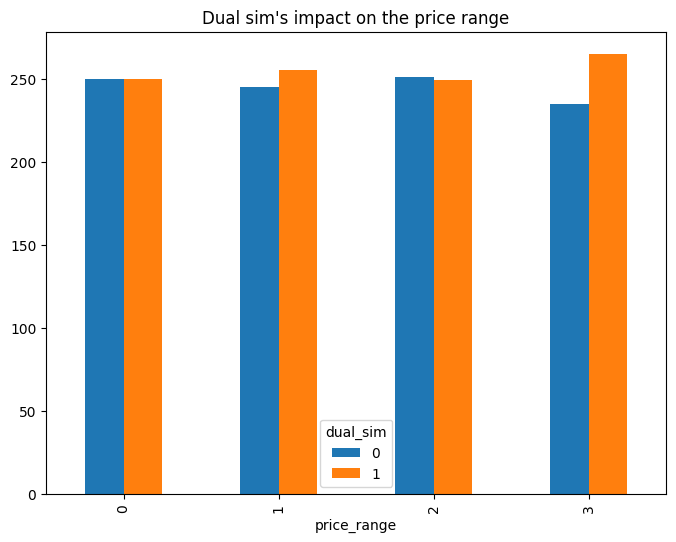

In [6]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
a = pd.crosstab(data["price_range"], data["dual_sim"]).plot.bar(ax = ax)
ax.set_title("Dual sim's impact on the price range")

- Having a dual sim is not as informative as I thought. For higher end mobile phones, there is a slight distinction between those who do have a dual sim and those who don't, clients that are looking for an expensive phone look for this feature a bit more than the others

# 2 - Feature Selection and Engineering

### Distinguishing variable types:
- Ordinal: discrete ordered variables
- Numerical: continous (high cardinality) variables
- Binary: nominal (no order) variables with 2 classes only

In [7]:
data.nunique().sort_values(ascending=False)

ram              1562
px_height        1137
px_width         1109
battery_power    1094
mobile_wt         121
int_memory         63
clock_speed        26
pc                 21
fc                 20
sc_w               19
talk_time          19
sc_h               15
m_dep              10
n_cores             8
price_range         4
blue                2
four_g              2
dual_sim            2
three_g             2
touch_screen        2
wifi                2
dtype: int64

In [8]:
binary_cols = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
ordinal_cols = ['n_cores']
numerical_cols = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']
target = ['price_range']
print(set(list(binary_cols + ordinal_cols + target + numerical_cols)) == set(list(data.columns)))

True


### Checking for multicolinearity
- Multicolinearity can help us remove redundant features from the dataset aswell as finding relatonships between features and thus better understanding the dataset

- Using pairplots for numerical variables

In [9]:
# sns.pairplot(data[numerical_cols + target], hue = "price_range")

- Ram and Battery Power seem to be 2 of the most indicative variables, aswell as the dimension variables (screen width & height, pixel width & height)
- Aside these dimension variables, no other variables seem to have high correlation, we can better visualise this using a correlation matrix

## Numerical and Ordinal Features: Heatmap and correlation analysis

<Axes: >

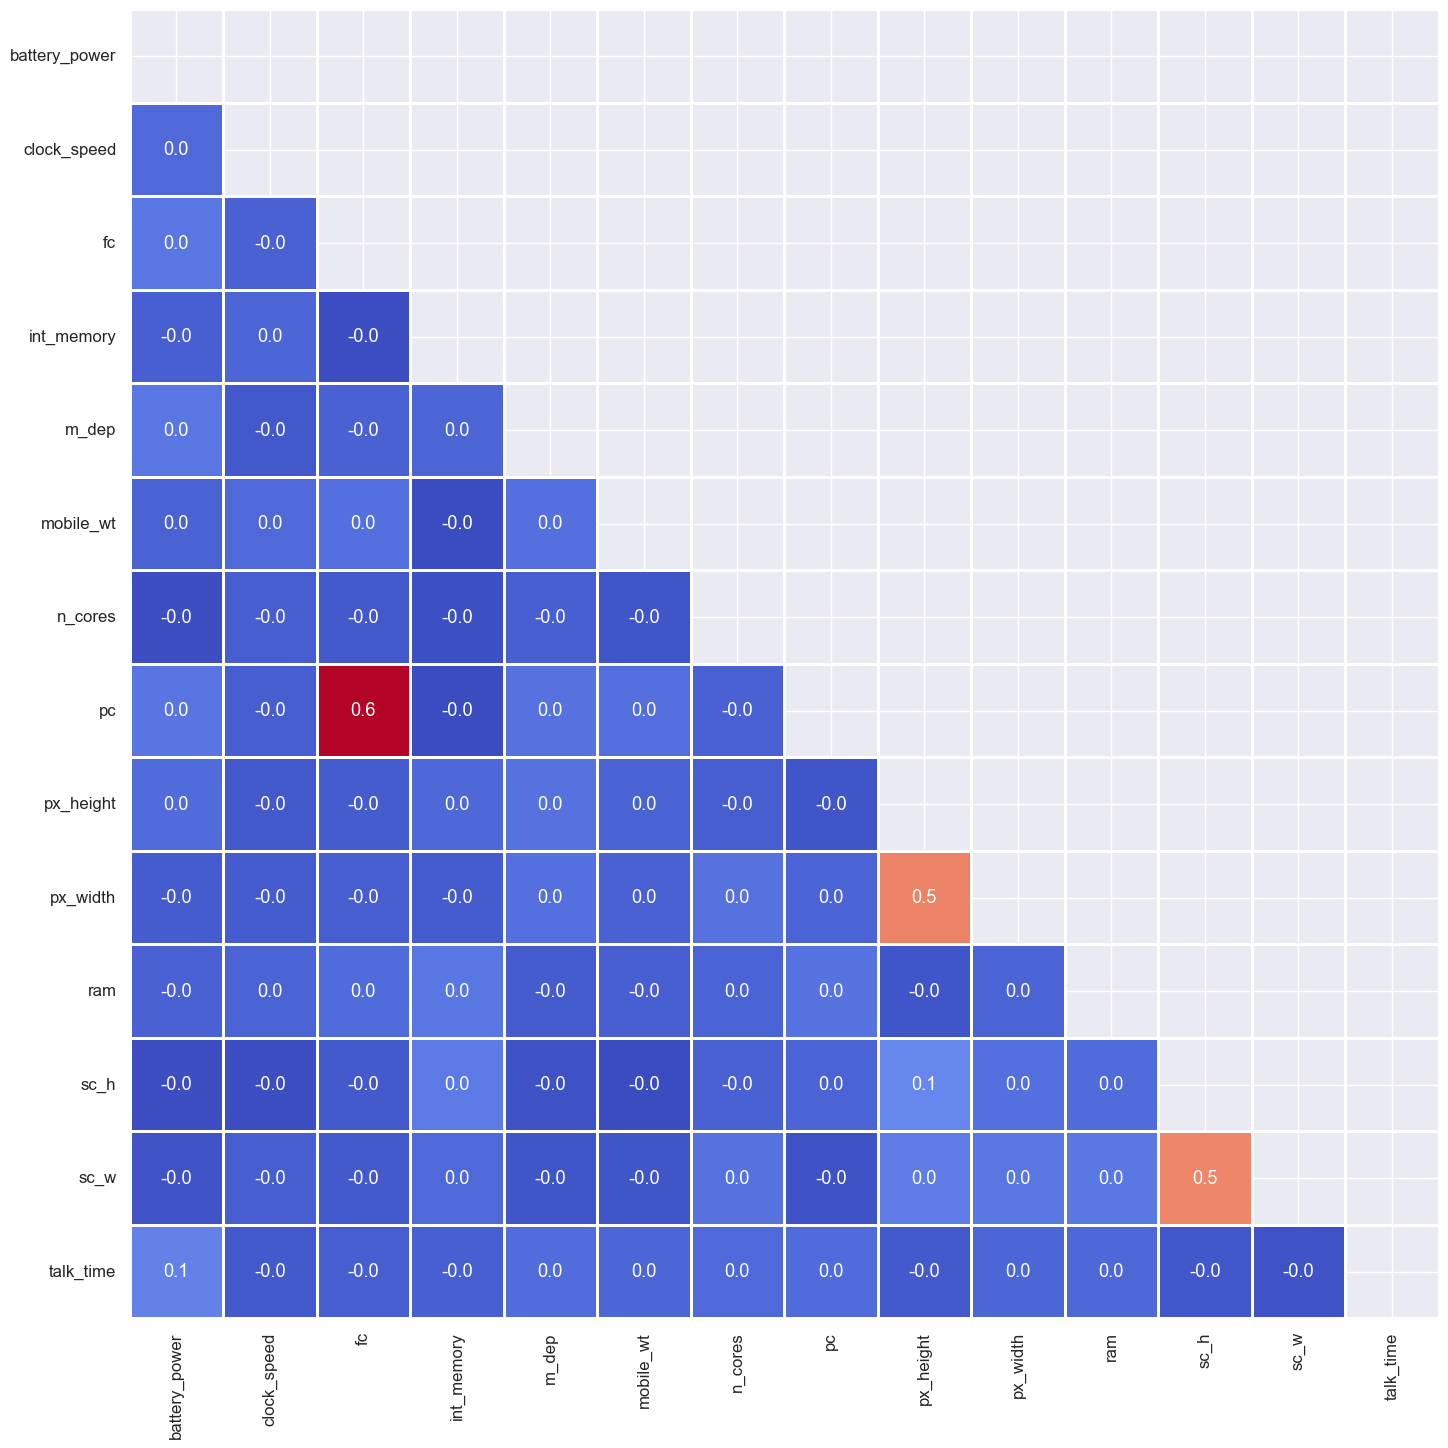

In [10]:
sns.set(font_scale=1.1)
correlation_train = data[numerical_cols].corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(17, 17))
sns.heatmap(correlation_train,
annot=True,
fmt='.1f',
cmap='coolwarm',
square=True,
mask=mask,
linewidths=1,
cbar=False)

* Some independant variables are correlated to each other:
  - Which is normal, width and height are likely to be correlated for screen size and pixel resolution
  - Same goes for front camera resolution (fc) and back camera resolution (bc)
* To better see the impact of these correlations, we can compute the Variance Inflation Factor

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = data[numerical_cols].copy()
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X_vif.columns))]
  
display(vif_data.sort_values(by = "VIF", ascending= False))

,feature,VIF
8,px_height,12.972548
12,sc_w,11.766282
0,battery_power,8.076717
10,ram,6.228797
13,talk_time,4.688608
9,px_width,4.646070
11,sc_h,4.262680
2,fc,4.260479
6,n_cores,3.961239
7,pc,3.911115


- Scores above 10 are not a good sign, we'll start by merging the width and height variables into an aspect ratio (height/width)

In [12]:
print(X_vif.loc[X_vif["px_width"] == 0].shape[0])
print(X_vif.loc[X_vif["sc_w"] == 0].shape[0])

0
180


- Some screen widths are equal to 0, this is physically impossible and probably a forgotten measure
- Let's check if the corresponding heights can give us insights on why the data is missing

2023-10-05 19:18:11,333 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-10-05 19:18:11,348 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='sc_h', ylabel='sc_w'>

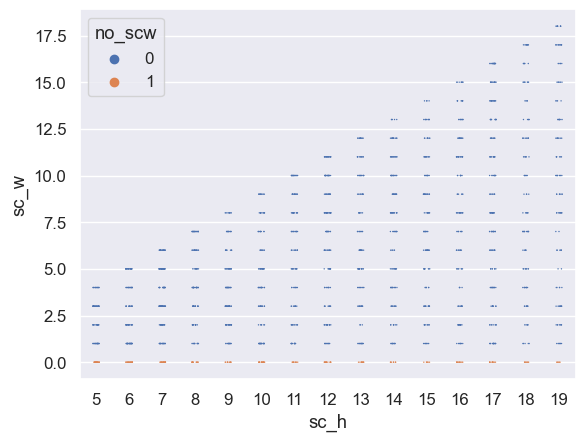

In [13]:
X_vif = data[numerical_cols].copy()
X_vif["no_scw"] = X_vif.apply(lambda x: 1 if x["sc_w"] == 0 else 0, axis = 1)
sns.stripplot(data = X_vif, x = "sc_h", y = "sc_w", hue= "no_scw", size = 1)

- No clear patterns, we'll keep the the flag for missing values and impute the 0 with the mode of the corresponding group of heights

2023-10-05 19:18:11,721 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-10-05 19:18:11,729 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='sc_h', ylabel='sc_w'>

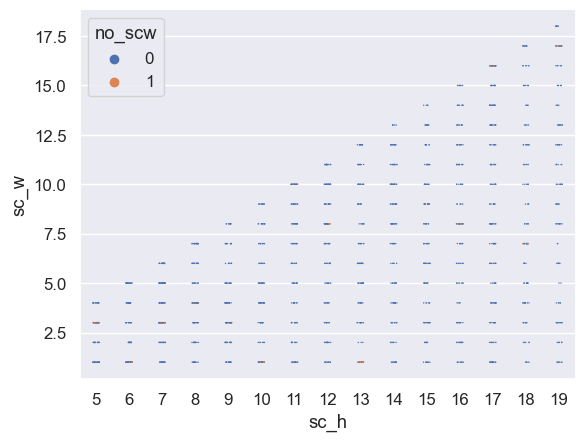

In [14]:
imputation_dict = {}
for height in list(X["sc_h"].unique()):
    imputation_dict[str(height)] = X_vif.loc[X_vif["sc_h"] == height, "sc_w"].mode().values[0]

def null_width(row):
    if row["sc_w"] == 0:
        return imputation_dict[str(row["sc_h"].astype("int"))]
    else:
        return row["sc_w"]

X_vif = data[numerical_cols].copy()
X_vif["no_scw"] = X_vif.apply(lambda x: 1 if x["sc_w"] == 0 else 0, axis = 1)
X_vif["sc_w"] = X_vif.apply(null_width, axis = 1)
sns.stripplot(data = X_vif, x = "sc_h", y = "sc_w", hue= "no_scw", size = 1)

- The zero width rows are distributed within each height category, we can compute the aspect ratios

In [15]:
X_vif["aspect_ratio"] = X_vif["sc_h"]/X_vif["sc_w"]
X_vif["pixel_ratio"] = X_vif["px_height"]/X_vif["px_width"]
X_vif.drop(["sc_h", "sc_w", "px_height", "px_width"], axis = 1, inplace= True)
logger.info(display(X_vif))
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                          for i in range(len(X_vif.columns))]
  
display(vif_data.sort_values(by = "VIF", ascending= False))

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,ram,talk_time,no_scw,aspect_ratio,pixel_ratio
0,842,2.2,1,7,0.6,188,2,2,2549,19,0,1.285714,0.026455
1,1021,0.5,0,53,0.7,136,3,6,2631,7,0,5.666667,0.455231
2,563,0.5,2,41,0.9,145,5,6,2603,9,0,5.500000,0.736014
3,615,2.5,0,10,0.8,131,6,9,2769,11,0,2.000000,0.680851
4,1821,1.2,13,44,0.6,141,2,14,1411,15,0,4.000000,0.996700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,0.5,0,2,0.8,106,6,14,668,19,0,3.250000,0.646561
1996,1965,2.6,0,39,0.2,187,4,3,2032,16,0,1.100000,0.465649
1997,1911,0.9,1,36,0.7,108,8,3,3057,5,0,9.000000,0.531863
1998,1512,0.9,4,46,0.1,145,5,5,869,19,0,1.800000,0.501493


2023-10-05 19:18:12,147 - __main__ - INFO - None


,feature,VIF
5,mobile_wt,11.786723
0,battery_power,7.802831
7,pc,6.167216
9,talk_time,4.772771
8,ram,4.529254
6,n_cores,4.451668
1,clock_speed,4.204607
12,pixel_ratio,3.931280
4,m_dep,3.868886
3,int_memory,3.842852


- We still have some high VIFs, but will use another criterion to select the best features

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,ram,talk_time,aspect_ratio,pixel_ratio
F statistic,3.159816e+01,0.493708,0.772182,2.922996,1.500682,3.594318,2.625415,0.825446,3520.110824,1.628811,1.370389,4.170231
p-value,5.948688e-20,0.686675,0.509504,0.032777,0.212459,0.013117,0.048936,0.479749,0.000000,0.180669,0.250039,0.005922


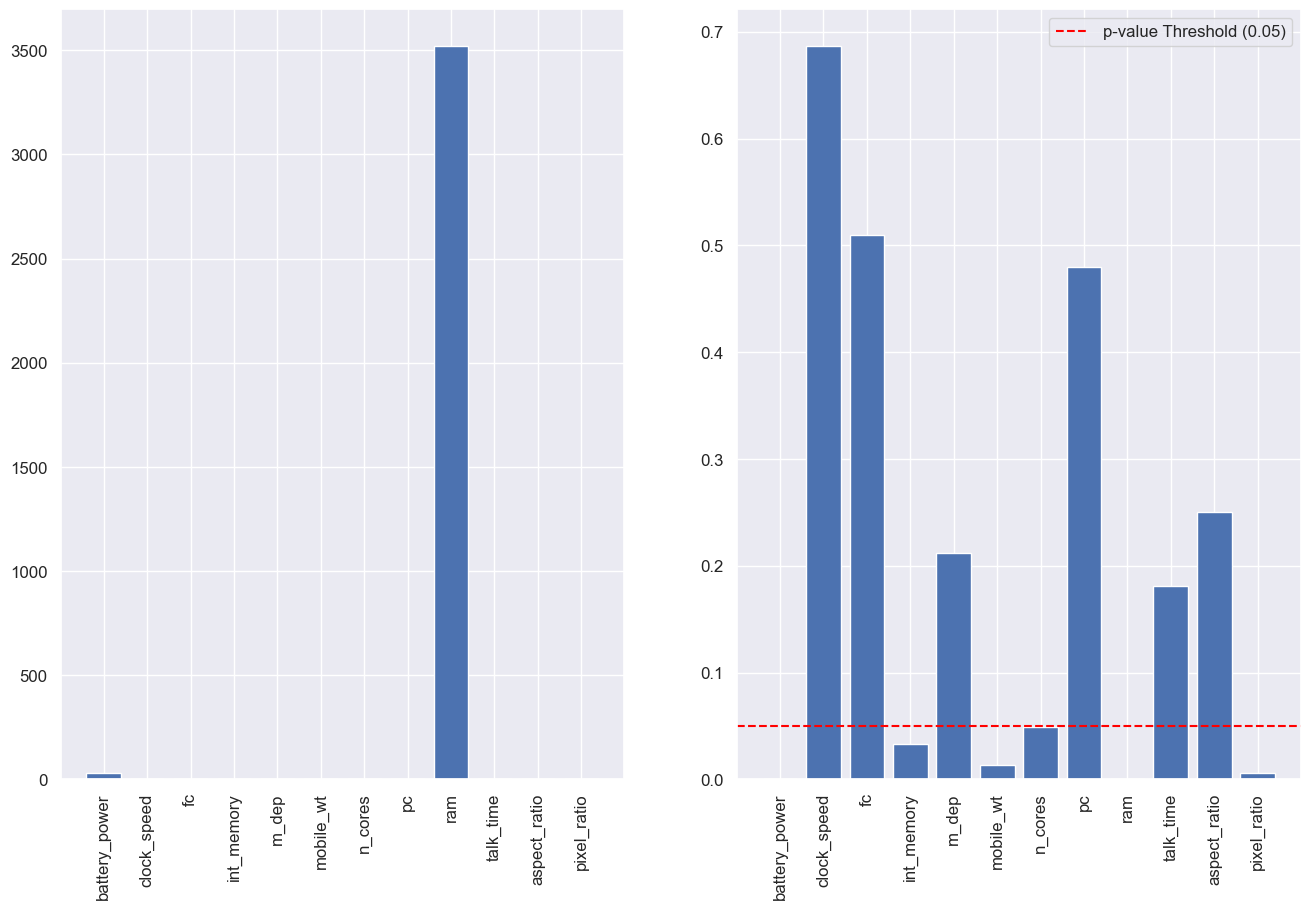

In [16]:
from sklearn import feature_selection as fs
X_anova_f = X_vif.drop("no_scw", axis = 1)
f_stat_kb = fs.SelectKBest(score_func=fs.f_classif, k='all')
f_stat_kb.fit(X_anova_f, y)
X_fs = f_stat_kb.transform(X_anova_f)
display(pd.DataFrame([f_stat_kb.scores_, f_stat_kb.pvalues_], columns=X_anova_f.columns, index=["F statistic", "p-value"]))
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax = ax.flatten()
ax[0].bar(range(len(f_stat_kb.scores_)), f_stat_kb.scores_)
ax[0].set_xticks(range(len(f_stat_kb.scores_)))
ax[0].set_xticklabels(X_anova_f.columns, rotation=90)
ax[1].bar(range(len(f_stat_kb.pvalues_)), f_stat_kb.pvalues_)
ax[1].set_xticks(range(len(f_stat_kb.pvalues_)))
ax[1].set_xticklabels(X_anova_f.columns, rotation=90)
ax[1].axhline(y=0.05, color='red', linestyle='--', label=f'p-value Threshold (0.05)')
ax[1].legend()
plt.show()

* Ram is by far the best predictor in terms of the between groups variance just like we saw in the previous histograms.
* Using a p-value threshold of 0.05, we would select the 6 best predictors as follows
    - ram
    - mobile_wt
    - int_memory
    - n_cores
    - pixel_ratio
    - battery_power
* We can also retry computing the vif scores

In [17]:
X_vif2 = X_vif.drop("no_scw", axis = 1)
f_stat_kb = fs.SelectKBest(score_func=fs.f_classif, k=6)
f_stat_kb.fit(X_vif2, y)
X_vif2 = pd.DataFrame(f_stat_kb.transform(X_vif2), columns = f_stat_kb.get_feature_names_out())

In [18]:
vif_data2 = pd.DataFrame()
vif_data2["feature"] = X_vif2.columns
vif_data2["VIF"] = [variance_inflation_factor(X_vif2.values, i)
                          for i in range(len(X_vif2.columns))]
  
display(vif_data2.sort_values(by = "VIF", ascending= False))

,feature,VIF
2,mobile_wt,9.905977
0,battery_power,7.118030
4,ram,4.380788
3,n_cores,4.310017
5,pixel_ratio,3.869158
1,int_memory,3.760204


- All vif scores are below 10 which will be accepted for now as a threshold, however if the model doesn't perform well, the still present multicolinearity might be a potential issue, especially since no visible relationship is visible

In [19]:
# sns.pairplot(pd.concat([X_vif2, y], axis = 1), hue = "price_range")

## Binary features: chi2 independance test

In [20]:
X_2 = X.copy()
binary_cols = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi', 'no_scw']
X_2["no_scw"] = X_2.apply(lambda x: 1 if x["sc_w"] == 0 else 0, axis = 1)
X_2 = X_2[binary_cols]
X_2

,blue,dual_sim,four_g,three_g,touch_screen,wifi,no_scw
0,0,0,0,0,0,1,0
1,1,1,1,1,1,0,0
2,1,1,1,1,1,0,0
3,1,0,0,1,0,0,0
4,1,0,1,1,1,0,0
...,...,...,...,...,...,...,...
1995,1,1,1,1,1,0,0
1996,1,1,0,1,1,1,0
1997,0,1,1,1,1,0,0
1998,0,0,1,1,1,1,0


(0.0, 1.0, 0.0, 1.0)

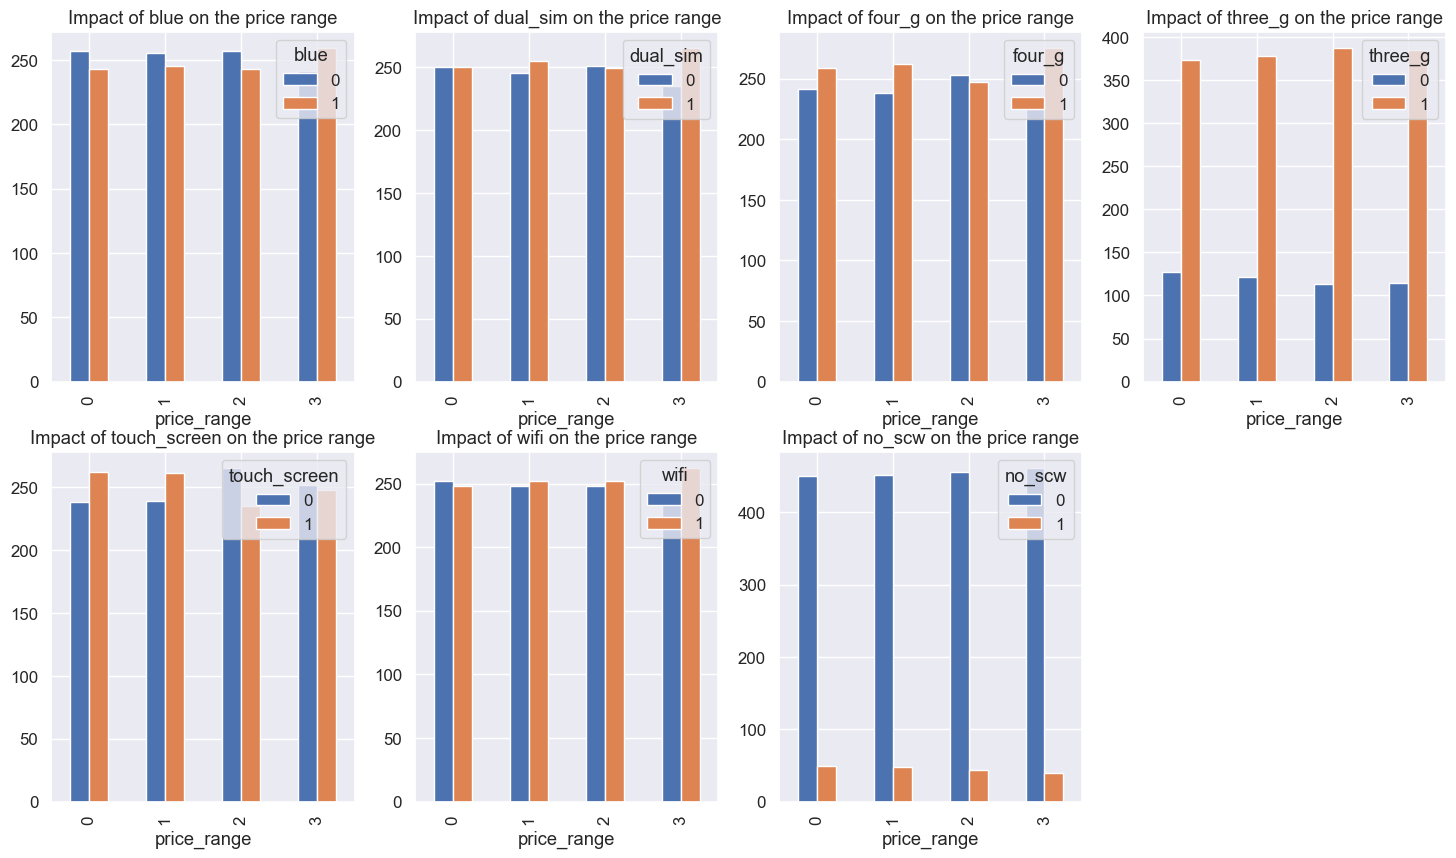

In [21]:
fig, ax = plt.subplots(2, 4, figsize=(18, 10))
for axis, col in zip(ax.flatten()[:-1], list(X_2.columns)):
    pd.crosstab(y, X_2[col]).plot.bar(ax=axis)
    axis.set_title(f"Impact of {col} on the price range")

#Leave the last subplot empty
ax[-1, -1].axis('off')

- Seems like none of the binary variables are good predictors, let's test this statistically

,blue,dual_sim,four_g,three_g,touch_screen,wifi,no_scw
F statistic,0.723232,0.631011,1.521572,0.327643,1.928429,0.422091,1.377778
p-value,0.867726,0.889298,0.677300,0.954748,0.587394,0.935642,0.710752


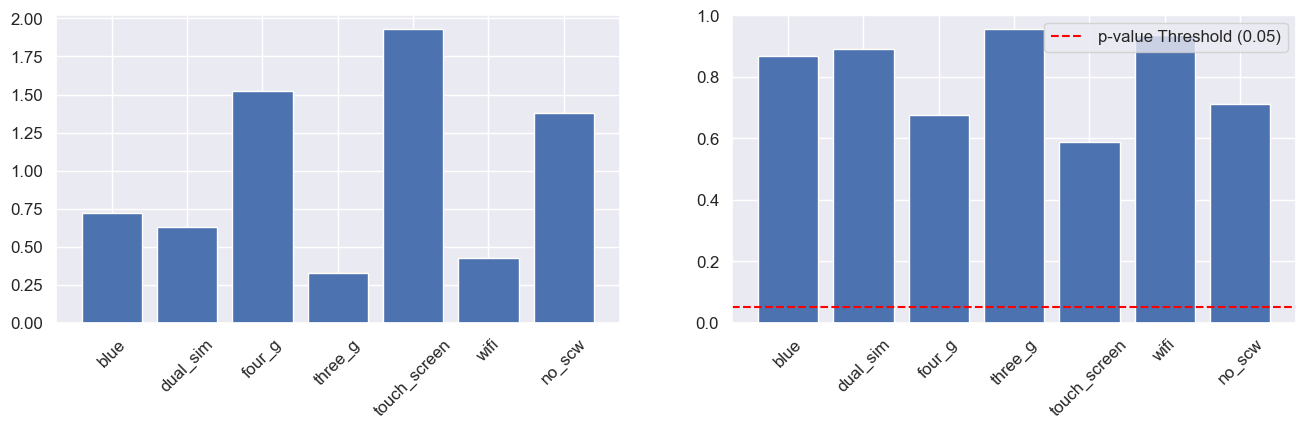

In [22]:
from sklearn import feature_selection as fs
f_stat_chi2 = fs.SelectKBest(score_func=fs.chi2, k='all')
f_stat_chi2.fit(X_2, y)
X_chi2 = f_stat_chi2.transform(X_2)
display(pd.DataFrame([f_stat_chi2.scores_, f_stat_chi2.pvalues_], columns=X_2.columns, index=["F statistic", "p-value"]))
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax = ax.flatten()
ax[0].bar(range(len(f_stat_chi2.scores_)), f_stat_chi2.scores_)
ax[0].set_xticks(range(len(f_stat_chi2.scores_)))
ax[0].set_xticklabels(X_2.columns, rotation=45)
ax[1].bar(range(len(f_stat_chi2.pvalues_)), f_stat_chi2.pvalues_)
ax[1].set_xticks(range(len(f_stat_chi2.pvalues_)))
ax[1].set_xticklabels(X_2.columns, rotation=45)
ax[1].axhline(y=0.05, color='red', linestyle='--', label=f'p-value Threshold (0.05)')
ax[1].legend()
plt.show()

- The Chi2 test for independance isn't rejected for any variable just like we suspected, meaning that they are just no informative enough

## Recursive Feature Elimination

- Whilst using these statistical tests can give good insights on which variables are good or bad predictors, it doesn't look the effect of the combinations between variables. Let us use Recursive Feature Elimination to confirm this

In [23]:
X = data.drop('price_range', axis=1)
y = data['price_range']

imputation_dict = {}
for height in list(X["sc_h"].unique()):
    imputation_dict[str(height)] = X.loc[X["sc_h"] == height, "sc_w"].mode().values[0]

def null_width(row):
    if row["sc_w"] == 0:
        return imputation_dict[str(row["sc_h"].astype("int"))]
    else:
        return row["sc_w"]

X["no_scw"] = X.apply(lambda x: 1 if x["sc_w"] == 0 else 0, axis = 1)
X["sc_w"] = X.apply(null_width, axis = 1)
X["aspect_ratio"] = X["sc_h"]/X["sc_w"]
X["pixel_ratio"] = X["px_height"]/X["px_width"]

In [24]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

rfe_models = [ensemble.RandomForestClassifier(), tree.DecisionTreeClassifier()]

result_dict = {}
for model in rfe_models:
    rf_classifier = model
    rfe = fs.RFE(estimator=model, n_features_to_select=None)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    rf_classifier.fit(X_train_rfe, y_train)
    X_test_rfe = rfe.transform(X_test)
    y_pred = rf_classifier.predict(X_test_rfe)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    result_dict[str(model)] = [f for f, mask in zip(X_train.columns, rfe.support_) if mask]

selected_features = pd.DataFrame.from_dict(result_dict, orient='index', columns=[f'Feature {i+1}' for i in range(max(map(len, result_dict.values())))])
selected_features.index = ["Random Forest", "Decision Tree"]
display(selected_features)

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11
Random Forest,battery_power,int_memory,mobile_wt,pc,px_height,px_width,ram,sc_h,talk_time,aspect_ratio,pixel_ratio
Decision Tree,battery_power,clock_speed,m_dep,mobile_wt,n_cores,px_height,px_width,ram,talk_time,aspect_ratio,pixel_ratio


- We do find within the 2 selected models for the RFE the prevalent anova f-test features and no binary ones. To avoid dropping any informative features, we will keep all numerical features until further analysis

# 3 - Data Preprocessing

* Let's put all our work together in a single pipeline:
    - Feature selection using the variables found earlier (dropping binary features)
    - Standardizing the data since the scales are quite different (if needed)

* The custom imputation and feature engineering won't be used unless the base performances without them aren't good enough

In [ ]:
ordinal_cols = ['n_cores']
numerical_cols = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'pc', 'ram', 'talk_time']
target = ['price_range']

In [214]:
def define_pipeline(model=None, scaler = False):
    """
    Function to create a pipeline with a certain model as an argument
    If no model is passed, only the preprocessing steps are instanciated
    """
    preprocessing_steps = [
        #('custom_imputer', CustomImputer()),
        #('aspect_and_pixel_ratio', DimensionVariables()),
    ]

    if scaler:
        preprocessing_steps.append(('standardizer', preprocessing.StandardScaler()))
    
    if model is not None:
        preprocessing_steps.append((f"model_{str(model).split('(')[0]}", model))
    
    pipeline = Pipeline(preprocessing_steps)
    return pipeline

In [215]:
y = data["price_range"]
X = data.drop("price_range", axis = 1, inplace=False)
X = X.drop(binary_cols, axis = 1)

- Testing the Pipeline

In [216]:
# With scaling
prep = define_pipeline()
display(pd.DataFrame(prep.fit_transform(X), columns=prep["standardizer"].feature_names_in_))

# Without scaling
# prep = define_pipeline(tree=True)
# display(pd.DataFrame(prep.fit_transform(X)))

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time
0,-0.902597,0.830779,-0.762495,-1.380644,0.340740,1.349249,-1.101971,-1.305750,-1.408949,-1.146784,0.391703,-0.784983,0.283103,1.462493
1,-0.495139,-1.253064,-0.992890,1.155024,0.687548,-0.120059,-0.664768,-0.645989,0.585778,1.704465,0.467317,1.114266,-0.635317,-0.734267
2,-1.537686,-1.253064,-0.532099,0.493546,1.381165,0.134244,0.209639,-0.645989,1.392684,1.074968,0.441498,-0.310171,-0.864922,-0.368140
3,-1.419319,1.198517,-0.992890,-1.215274,1.034357,-0.261339,0.646842,-0.151168,1.286750,1.236971,0.594569,0.876859,0.512708,-0.002014
4,1.325906,-0.395011,2.002254,0.658915,0.340740,0.021220,-1.101971,0.673534,1.268718,-0.091452,-0.657666,-1.022389,-0.864922,0.730240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1.011860,-1.253064,-0.992890,-1.656260,1.034357,-0.967737,0.646842,0.673534,1.300273,1.477661,-1.342799,0.164641,-0.405712,1.462493
1996,1.653694,1.321096,-0.992890,0.383299,-1.046495,1.320993,-0.227564,-1.140810,0.608317,1.651235,-0.085031,-0.310171,0.971917,0.913303
1997,1.530773,-0.762748,-0.762495,0.217930,0.687548,-0.911225,1.521249,-1.140810,0.502383,0.880565,0.860139,-0.784983,-1.094526,-1.100394
1998,0.622527,-0.762748,-0.071307,0.769162,-1.393304,0.134244,0.209639,-0.810929,-0.696707,-1.345816,-1.157454,1.351672,0.971917,1.462493


# 4 - Model Building

In [281]:
#Function to display confusion matrices

def modified_confusion_matrix(y_pred, y_val, model_name):
    cm = metrics.confusion_matrix(y_pred, y_val)

    scores_df = pd.DataFrame(metrics.precision_recall_fscore_support(y_pred, y_val)).T
    scores_df.columns = ["precision", "recall", "fscore", "support"]
    scores_df[['precision', 'recall', 'fscore']] = scores_df[['precision', 'recall', 'fscore']] * 100
    scores_df = scores_df.round({'precision': 2, 'recall': 2, 'fscore': 2})
    overall_accuracy = "{:.2%}".format(metrics.accuracy_score(y_pred, y_val))
    res = pd.concat([pd.DataFrame(cm), scores_df['recall']], axis = 1)
    res = pd.concat([res, scores_df['precision'].to_frame().T], axis = 0)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    heatmap = sns.heatmap(res, annot=True, fmt='g', cmap="YlOrRd", cbar_kws={'shrink': 0.8})
    ax.set_xticklabels([str(i) for i in range(4)] + ["Recall"])
    ax.set_yticklabels([str(i) for i in range(4)] + ["Precision"])
    ax.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True, length=0)
    plt.ylabel('Predicted Labels')
    ax.set_title(f"Confusion Matrix for the {model_name} Model " + f"({overall_accuracy} accuracy)" + '\n' + '\n' + r"True Labels", multialignment='center')
    ax.set_frame_on(False)
    plt.show()

For the rest of the analysis, a 5 fold cross validation metric will be used, if a confusion matrix is shown, it has been obtained from a classic train test split (80% test)

The metric is the accuracy since there are no class preferences, therefore no reason to privilege neither precision nor recall

## 1 - Logistic Regression

Average model score over 5 folds: 96.90%


Pipeline(steps=[('standardizer', StandardScaler()),
                ('model_LogisticRegression', LogisticRegression())])

This treeview is honestly beautiful


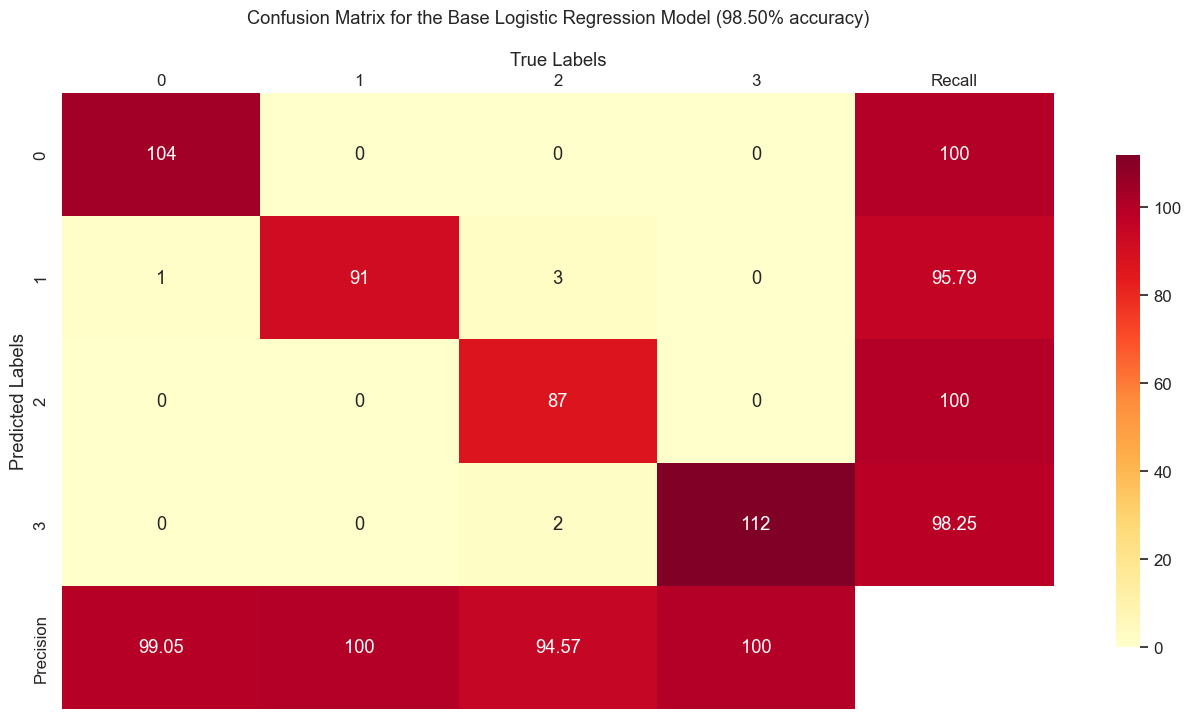

In [312]:
LR = define_pipeline(linear_model.LogisticRegression())
cv_score = "{:.2%}".format(model_selection.cross_val_score(LR, X, y, scoring='accuracy', cv = 5).mean())
print(f"Average model score over 5 folds: {cv_score}")
display(LR)
print("This treeview is honestly beautiful")

X_train, X_val, y_train, y_val= model_selection.train_test_split(X, y, train_size=0.8, random_state=42)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_val)

modified_confusion_matrix(y_pred, y_val, "Base Logistic Regression")

- Hyperparameter tuning is worth a try, even if (Logistic Regression doesn't have that many hyperparameters):

Average model score over 5 folds: 97.20%


Pipeline(steps=[('standardizer', StandardScaler()),
                ('model_GridSearchCV',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                              estimator=LogisticRegression(),
                              param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                1000],
                                          'penalty': ['l2']}))])

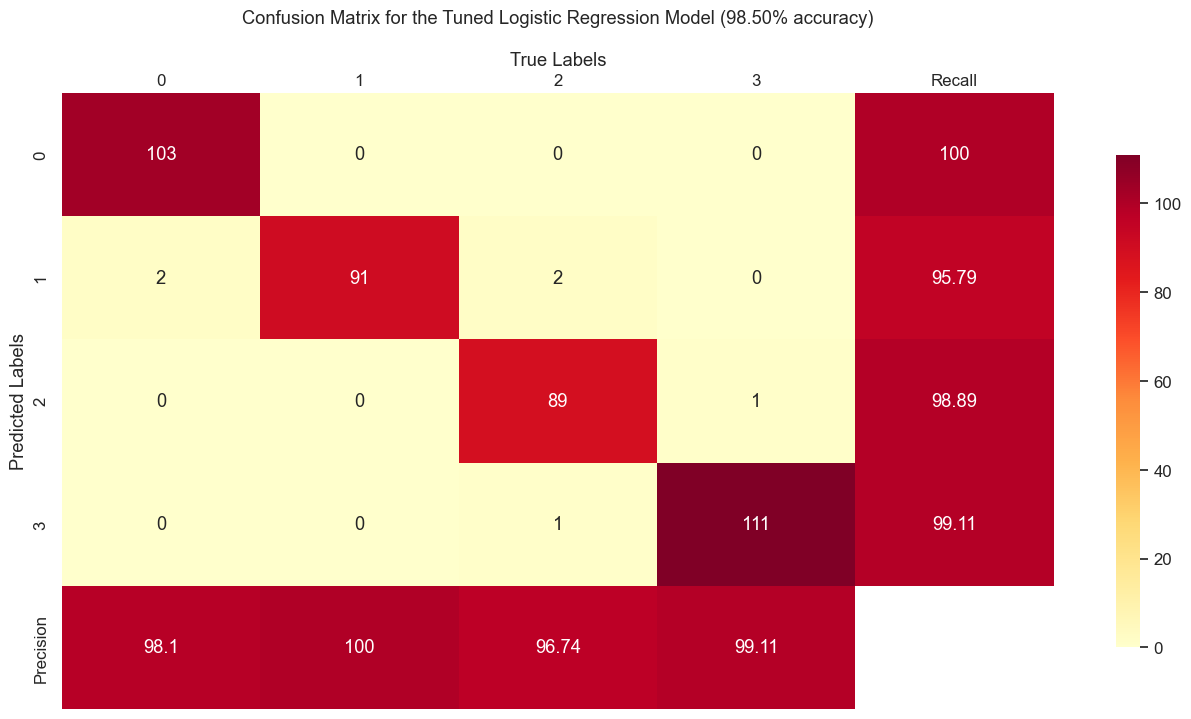

In [327]:
param_LR= {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2']}

folds_LR = model_selection.StratifiedKFold(n_splits = 5, shuffle = True)
tuned_model_LR = model_selection.GridSearchCV(linear_model.LogisticRegression(),
                                           param_grid=param_LR,
                                           cv=folds_LR)

LR_hyper = define_pipeline(tuned_model_LR, tree=False)
cv_score = "{:.2%}".format(model_selection.cross_val_score(LR_hyper, X, y, scoring='accuracy', cv = 5).mean())
print(f"Average model score over 5 folds: {cv_score}")
display(LR_hyper)
LR_hyper.fit(X_train, y_train)


LR_best = define_pipeline(linear_model.LogisticRegression(**LR_hyper[1].best_params_), tree=False)
X_train, X_val, y_train ,y_val= model_selection.train_test_split(X, y, train_size=0.8, random_state=42)
LR_best.fit(X_train, y_train)
y_pred = LR_best.predict(X_val)

import pickle
#pickle.dump({"Best_LogReg": LR_best}, open('LogReg' + ".p", "wb" ) )

modified_confusion_matrix(y_pred, y_val, "Tuned Logistic Regression")

- Slight improvement with the tuned model (on the 5 folds), overall Logistic Regression works very well for this datase, let's try different models

## 2 - Random Forest

### Baseline

In [284]:
X_train, X_val, y_train, y_val= model_selection.train_test_split(X, y, train_size=0.8, random_state=42)
RF = define_pipeline(ensemble.RandomForestClassifier(), tree = True)
cv_score = "{:.2%}".format(model_selection.cross_val_score(RF, X, y, scoring='accuracy', cv = 5).mean())
print(f"Average model score over 5 folds: {cv_score}")
display(RF)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_val)

#modified_confusion_matrix(y_pred, y_val, "Base Random Forest")

Average model score over 5 folds: 88.55%


Pipeline(steps=[('model_RandomForestClassifier', RandomForestClassifier())])

### Tuned model (bayesion optimization):

- Since computation time is too costly (a lot of hyperparameter combinations for a random forest), we'll use skopt to tune the model, the gp_minimize is commented out to avoid computing a second time

In [287]:
#Credits to ChromaticIsobar for skopt bug fix https://github.com/scikit-optimize/scikit-optimize/issues/1138
np.int = int

def optimize(params, param_names, X, y):
    params = dict(zip(param_names, params))
    RF_bo = define_pipeline(ensemble.RandomForestClassifier(**params), tree=True)
    display(RF_bo)
    kf = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []
    for idx in kf.split(X=X, y=y):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = X.iloc[train_idx]
        ytrain = y.iloc[train_idx]
        xtest = X.iloc[test_idx]
        ytest = y.iloc[test_idx]
        RF_bo.fit(xtrain, ytrain)
        preds = RF_bo.predict(xtest)
        fold_acc = metrics.accuracy_score(ytest, preds)
        accuracies.append(fold_acc)
    return -1.0 * np.mean(accuracies)

param_space = [
    space.Categorical([True, False], name='bootstrap'),
    space.Integer(10, 100, name='max_depth'),
    space.Real(0.01, 1, prior="uniform", name='max_features'),
    space.Integer(1, 4, name='min_samples_leaf'),
    space.Integer(2, 10, name='min_samples_split'),
    space.Integer(200, 2000, name='n_estimators')
]

param_name = [item.name for item in param_space]

optimization_function = partial(optimize, param_names=param_name, X=X, y=y)

# result = gp_minimize(
#     optimization_function,
#     dimensions=param_space,
#     n_calls=10,
#     n_random_starts=10,
#     verbose=10
# )

# print(dict(zip(param_name, result.x)))

import pickle
# pickle.dump({"Best_RF": dict(zip(param_name, result.x))}, open('RF' + ".p", "wb" ) )

with open("../src/RF.p", 'rb') as pickled:
    data = pickle.load(pickled)
    RF_tuned = data["Best_RF"]

RF_best = define_pipeline(ensemble.RandomForestClassifier(**RF_tuned), tree=True)
cv_score = "{:.2%}".format(model_selection.cross_val_score(RF_best, X, y, scoring='accuracy', cv = 5).mean())
print(f"Average model score over 5 folds: {cv_score}")
display(RF_best)

Average model score over 5 folds: 90.05%


Pipeline(steps=[('model_RandomForestClassifier',
                 RandomForestClassifier(max_depth=46,
                                        max_features=0.7730640099862199,
                                        min_samples_split=3,
                                        n_estimators=735))])

- 2% improvement with the tuned model, but The Random Forest Classifier doesn't work aswell as Logistic Regression, having uninformative categorical values may be a reason

## 3 - Support Vector Machines

### Baseline

In [319]:
X_train, X_val, y_train, y_val= model_selection.train_test_split(X, y, train_size=0.8, random_state=42)
SVClassifier = define_pipeline(svm.SVC())
cv_score = "{:.2%}".format(model_selection.cross_val_score(SVClassifier, X, y, scoring='accuracy', cv = 5).mean())
print(f"Average model score over 5 folds: {cv_score}")
display(SVClassifier)
SVClassifier.fit(X_train, y_train)
y_pred = SVClassifier.predict(X_val)

#modified_confusion_matrix(y_pred, y_val, "Base Random Forest")

Average model score over 5 folds: 90.30%


Pipeline(steps=[('standardizer', StandardScaler()), ('model_SVC', SVC())])

### Tuned Model (RandomSearchCV)

In [291]:
X_train, X_val, y_train ,y_val= model_selection.train_test_split(X, y, train_size=0.8, random_state=42)

param_grid = {'C': list(np.linspace(0.1,100,100)),'kernel': ['linear', 'rbf']}

folds_SVM = model_selection.StratifiedKFold(n_splits = 5, shuffle = True)
random_model_SVM = model_selection.RandomizedSearchCV(svm.SVC(),
                                           param_distributions=param_grid,
                                           cv=folds_SVM,
                                           n_iter = 50,
                                           verbose=10)

SVM_random = define_pipeline(random_model_SVM, tree=False)
cv_score = "{:.2%}".format(model_selection.cross_val_score(SVM_random, X, y, scoring='accuracy', cv = 5).mean())
print(f"Average model score over 5 folds: {cv_score}")
display(SVM_random)
SVM_random.fit(X_train, y_train)

#A regularization parameter around 60 is the best when the cell was ran

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START C=81.83636363636363, kernel=rbf............................
[CV 1/5; 1/50] END C=81.83636363636363, kernel=rbf;, score=0.881 total time=   0.0s
[CV 2/5; 1/50] START C=81.83636363636363, kernel=rbf............................
[CV 2/5; 1/50] END C=81.83636363636363, kernel=rbf;, score=0.881 total time=   0.0s
[CV 3/5; 1/50] START C=81.83636363636363, kernel=rbf............................
[CV 3/5; 1/50] END C=81.83636363636363, kernel=rbf;, score=0.878 total time=   0.0s
[CV 4/5; 1/50] START C=81.83636363636363, kernel=rbf............................
[CV 4/5; 1/50] END C=81.83636363636363, kernel=rbf;, score=0.881 total time=   0.0s
[CV 5/5; 1/50] START C=81.83636363636363, kernel=rbf............................
[CV 5/5; 1/50] END C=81.83636363636363, kernel=rbf;, score=0.863 total time=   0.0s
[CV 1/5; 2/50] START C=91.92727272727272, kernel=linear.........................
[CV 1/5; 2/50] END C=91.92727272

Pipeline(steps=[('standardizer', StandardScaler()),
                ('model_RandomizedSearchCV',
                 RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                                    estimator=SVC(), n_iter=50,
                                    param_distributions={'C': [0.1,
                                                               1.1090909090909091,
                                                               2.118181818181818,
                                                               3.1272727272727274,
                                                               4.136363636363636,
                                                               5.145454545454545,
                                                               6.154545454545454,
                                                               7.163636363636363,
                                                               8.17272...
                                                               13.218181818181817,
                                                               14.227272727272727,
                                                               15.236363636363635,
                                                               16.245454545454546,
                                                               17.254545454545454,
                                                               18.263636363636365,
                                                               19.272727272727273,
                                                               20.28181818181818,
                                                               21.290909090909093,
                                                               22.3,
                                                               23.30909090909091,
                                                               24.31818181818182,
                                                               25.327272727272728,
                                                               26.336363636363636,
                                                               27.345454545454544,
                                                               28.354545454545455,
                                                               29.363636363636363, ...],
                                                         'kernel': ['linear',
                                                                    'rbf']},
                                    verbose=10))])

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START C=87.89090909090908, kernel=rbf............................
[CV 1/5; 1/50] END C=87.89090909090908, kernel=rbf;, score=0.894 total time=   0.0s
[CV 2/5; 1/50] START C=87.89090909090908, kernel=rbf............................
[CV 2/5; 1/50] END C=87.89090909090908, kernel=rbf;, score=0.878 total time=   0.0s
[CV 3/5; 1/50] START C=87.89090909090908, kernel=rbf............................
[CV 3/5; 1/50] END C=87.89090909090908, kernel=rbf;, score=0.897 total time=   0.0s
[CV 4/5; 1/50] START C=87.89090909090908, kernel=rbf............................
[CV 4/5; 1/50] END C=87.89090909090908, kernel=rbf;, score=0.909 total time=   0.0s
[CV 5/5; 1/50] START C=87.89090909090908, kernel=rbf............................
[CV 5/5; 1/50] END C=87.89090909090908, kernel=rbf;, score=0.859 total time=   0.0s
[CV 1/5; 2/50] START C=72.75454545454545, kernel=rbf............................
[CV 1/5; 2/50] END C=72.75454545

Pipeline(steps=[('standardizer', StandardScaler()),
                ('model_RandomizedSearchCV',
                 RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                                    estimator=SVC(), n_iter=50,
                                    param_distributions={'C': [0.1,
                                                               1.1090909090909091,
                                                               2.118181818181818,
                                                               3.1272727272727274,
                                                               4.136363636363636,
                                                               5.145454545454545,
                                                               6.154545454545454,
                                                               7.163636363636363,
                                                               8.17272...
                                                               13.218181818181817,
                                                               14.227272727272727,
                                                               15.236363636363635,
                                                               16.245454545454546,
                                                               17.254545454545454,
                                                               18.263636363636365,
                                                               19.272727272727273,
                                                               20.28181818181818,
                                                               21.290909090909093,
                                                               22.3,
                                                               23.30909090909091,
                                                               24.31818181818182,
                                                               25.327272727272728,
                                                               26.336363636363636,
                                                               27.345454545454544,
                                                               28.354545454545455,
                                                               29.363636363636363, ...],
                                                         'kernel': ['linear',
                                                                    'rbf']},
                                    verbose=10))])

### Tuned Model (GridSearchCV)

In [296]:
X_train, X_val, y_train ,y_val= model_selection.train_test_split(X, y, train_size=0.8, random_state=42)

param_grid = {'C': list(np.linspace(50,100,20)),'kernel': ['linear']}

folds_SVM = model_selection.StratifiedKFold(n_splits = 5, shuffle = True)
tuned_model_SVM = model_selection.GridSearchCV(svm.SVC(),
                                           param_grid=param_grid,
                                           cv=folds_SVM,
                                           verbose=10)

SVM_hyper = define_pipeline(tuned_model_SVM, tree=False)
cv_score = "{:.2%}".format(model_selection.cross_val_score(SVM_hyper, X, y, scoring='accuracy', cv = 5).mean())
print(f"Average model score over 5 folds: {cv_score}")
display(SVM_hyper)
SVM_hyper.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START C=50.0, kernel=linear......................................
[CV 1/5; 1/20] END .......C=50.0, kernel=linear;, score=0.966 total time=   0.0s
[CV 2/5; 1/20] START C=50.0, kernel=linear......................................
[CV 2/5; 1/20] END .......C=50.0, kernel=linear;, score=0.966 total time=   0.0s
[CV 3/5; 1/20] START C=50.0, kernel=linear......................................
[CV 3/5; 1/20] END .......C=50.0, kernel=linear;, score=0.947 total time=   0.0s
[CV 4/5; 1/20] START C=50.0, kernel=linear......................................
[CV 4/5; 1/20] END .......C=50.0, kernel=linear;, score=0.969 total time=   0.0s
[CV 5/5; 1/20] START C=50.0, kernel=linear......................................
[CV 5/5; 1/20] END .......C=50.0, kernel=linear;, score=0.981 total time=   0.0s
[CV 1/5; 2/20] START C=52.631578947368425, kernel=linear........................
[CV 1/5; 2/20] END C=52.631578947368425, kernel

Pipeline(steps=[('standardizer', StandardScaler()),
                ('model_GridSearchCV',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                              estimator=SVC(),
                              param_grid={'C': [50.0, 52.631578947368425,
                                                55.26315789473684,
                                                57.89473684210526,
                                                60.526315789473685,
                                                63.15789473684211,
                                                65.78947368421052,
                                                68.42105263157895,
                                                71.05263157894737,
                                                73.6842105263158,
                                                76.31578947368422,
                                                78.94736842105263,
                                                81.57894736842105,
                                                84.21052631578948,
                                                86.84210526315789,
                                                89.47368421052632,
                                                92.10526315789474,
                                                94.73684210526316,
                                                97.36842105263159, 100.0],
                                          'kernel': ['linear']},
                              verbose=10))])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START C=50.0, kernel=linear......................................
[CV 1/5; 1/20] END .......C=50.0, kernel=linear;, score=0.972 total time=   0.2s
[CV 2/5; 1/20] START C=50.0, kernel=linear......................................
[CV 2/5; 1/20] END .......C=50.0, kernel=linear;, score=0.978 total time=   0.1s
[CV 3/5; 1/20] START C=50.0, kernel=linear......................................
[CV 3/5; 1/20] END .......C=50.0, kernel=linear;, score=0.972 total time=   0.2s
[CV 4/5; 1/20] START C=50.0, kernel=linear......................................
[CV 4/5; 1/20] END .......C=50.0, kernel=linear;, score=0.978 total time=   0.1s
[CV 5/5; 1/20] START C=50.0, kernel=linear......................................
[CV 5/5; 1/20] END .......C=50.0, kernel=linear;, score=0.966 total time=   0.0s
[CV 1/5; 2/20] START C=52.631578947368425, kernel=linear........................
[CV 1/5; 2/20] END C=52.631578947368425, kernel

Pipeline(steps=[('standardizer', StandardScaler()),
                ('model_GridSearchCV',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                              estimator=SVC(),
                              param_grid={'C': [50.0, 52.631578947368425,
                                                55.26315789473684,
                                                57.89473684210526,
                                                60.526315789473685,
                                                63.15789473684211,
                                                65.78947368421052,
                                                68.42105263157895,
                                                71.05263157894737,
                                                73.6842105263158,
                                                76.31578947368422,
                                                78.94736842105263,
                                                81.57894736842105,
                                                84.21052631578948,
                                                86.84210526315789,
                                                89.47368421052632,
                                                92.10526315789474,
                                                94.73684210526316,
                                                97.36842105263159, 100.0],
                                          'kernel': ['linear']},
                              verbose=10))])

In [321]:
import pickle
#pickle.dump({"Best_SVM": define_pipeline(SVM_hyper[1].best_estimator_, tree=True)}, open('SVM' + ".p", "wb" ) )

with open("../src/SVM.p", 'rb') as pickled:
    data = pickle.load(pickled)
    SVM_tuned = data["Best_SVM"]

cv_score = "{:.2%}".format(model_selection.cross_val_score(SVM_tuned, X, y, scoring='accuracy', cv = 5).mean())
print(f"Average model score over 5 folds: {cv_score}")
display(SVM_tuned)

Average model score over 5 folds: 97.30%


Pipeline(steps=[('model_SVC', SVC(C=92.10526315789474, kernel='linear'))])

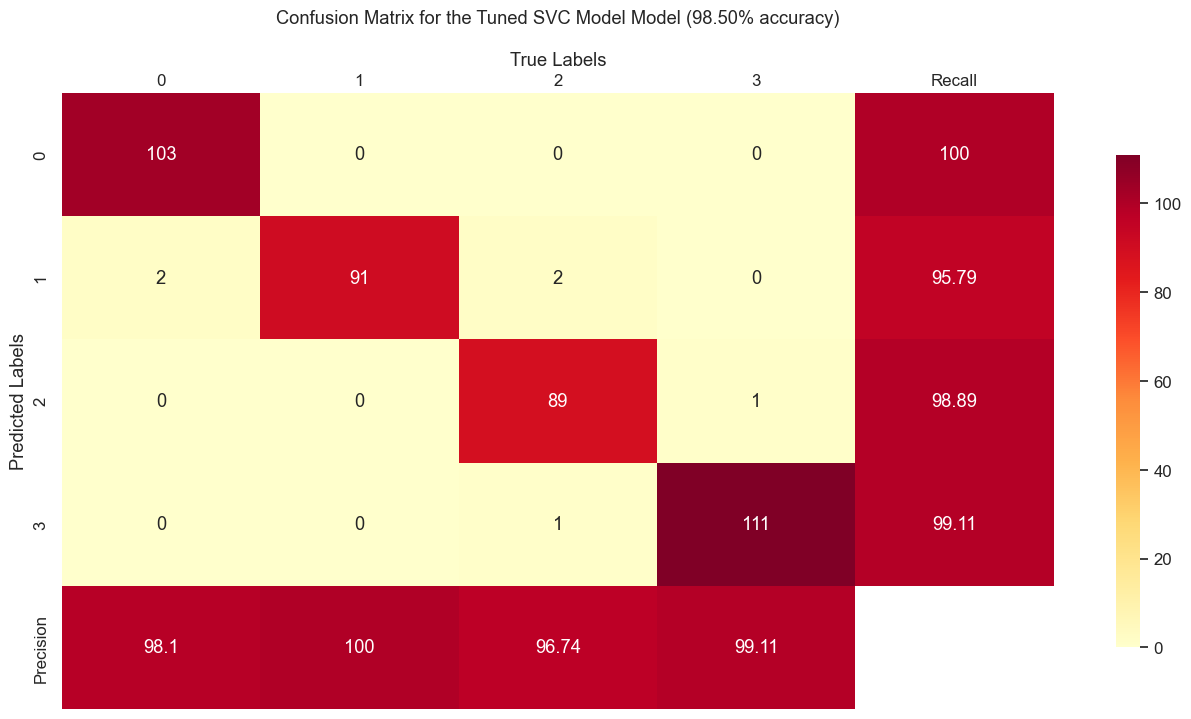

In [322]:
SVM_best = define_pipeline(SVM_tuned, tree=False)
SVM_best.fit(X_train, y_train)
y_pred = LR_best.predict(X_val)

modified_confusion_matrix(y_pred, y_val, "Tuned SVC Model")

# 5 - Model Choice and Analysis

- Let's summarize the model performances

In [323]:
summary = {
    '5-Fold Accuracy': ['97.50%', '90.05%', '97.30%']
}
display(pd.DataFrame(summary, index=['Logistic Regression', 'Random Forest', 'Support Vector Classifier']))

,5-Fold Accuracy
Logistic Regression,97.50%
Random Forest,90.05%
Support Vector Classifier,97.30%


- The accuracy is close between both Logistic Regression and Support Vector Classifier, with a slight edge for the Logistic Regression Model, since it is computationally less expensive, it will be the chosen model

In [328]:
with open("../src/SVM.p", 'rb') as pickled:
    data = pickle.load(pickled)
    SVM_tuned = data["Best_SVM"]

with open("../src/LogReg.p", 'rb') as pickled:
    data = pickle.load(pickled)
    LogReg_tuned = data["Best_LogReg"]